In [1]:
%matplotlib notebook
import os, sys
import logging
import random
import h5py
import shutil
import time
import argparse
import numpy as np
import sigpy.plot as pl
import torch
import sigpy as sp
import torchvision
from torch import optim
from tensorboardX import SummaryWriter
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
# import custom libraries
from utils import transforms as T
from utils import subsample as ss
from utils import complex_utils as cplx
from utils.resnet2p1d import generate_model
from utils.flare_utils import roll
# import custom classes
from utils.datasets import SliceData
from subsample_fastmri import MaskFunc
from MoDL_single import UnrolledModel
import argparse

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 2

/home/efrat/.local/lib/python3.6/site-packages/numba/core/errors.py:149: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


ModuleNotFoundError: No module named 'torch'

In [2]:
!pwd

/mikQNAP/kewang/demo_modl_singlechannel


In [3]:
!which python3

/home/efrat/anaconda3/bin/python3


In [8]:
da = h5py.File("test/training_set_16.h5", 'r')
kspace = np.array(da["kspace"])[21,...]
target = np.array(da["reconstruction"])[21,...]

In [35]:
im_lowres = abs(sp.ifft(sp.resize(sp.resize(kspace,(640,24)),(640,372))))
magnitude_vals = im_lowres.reshape(-1)
k = int(round(0.05 * magnitude_vals.shape[0]))
scale = magnitude_vals[magnitude_vals.argsort()[::-1][k]]
kspace = kspace/scale
target = target/scale
# Convert everything from numpy arrays to tensors
kspace_torch = cplx.to_tensor(kspace).float()   
target_torch = cplx.to_tensor(target).float()   
mask_slice = np.ones((640,372))
mask_func = MaskFunc([0.08],[4])
mk1 = mask_func((1,1,372,2))[0,0,:,0]
knee_masks = mask_slice*mk1
mask_torch = torch.tensor(knee_masks[...,None]).float()   
kspace_torch = kspace_torch*mask_torch

In [36]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [37]:
checkpoint_file = "checkpoints/model_6.pt"
checkpoint = torch.load(checkpoint_file,map_location=device)

In [38]:
params = checkpoint["params"]
single_MoDL = UnrolledModel(params).to(device)
single_MoDL.load_state_dict(checkpoint['model'])

shared weights


<All keys matched successfully>

In [39]:
kspace_torch.shape

torch.Size([640, 372, 2])

In [40]:
with torch.no_grad():
    kspace_torch = kspace_torch.unsqueeze(0).to(device)
    mask_torch = mask_torch.unsqueeze(0).to(device)
    im_out = single_MoDL(kspace_torch.float(),mask=mask_torch)

<IPython.core.display.Javascript object>


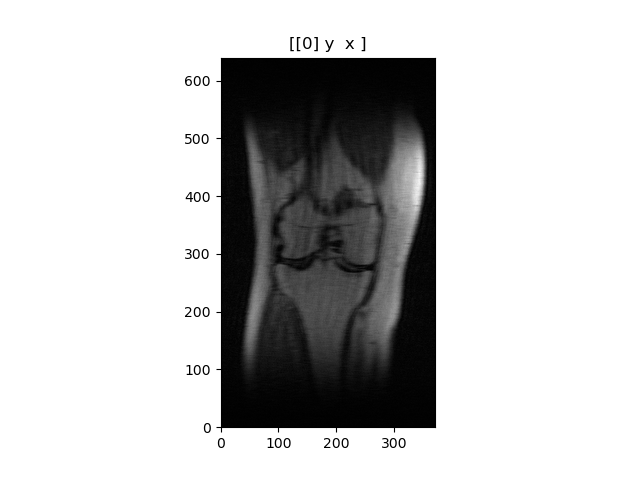

In [48]:
pl.ImagePlot(cplx.to_numpy(T.ifft2(kspace_torch.cpu())))

<IPython.core.display.Javascript object>


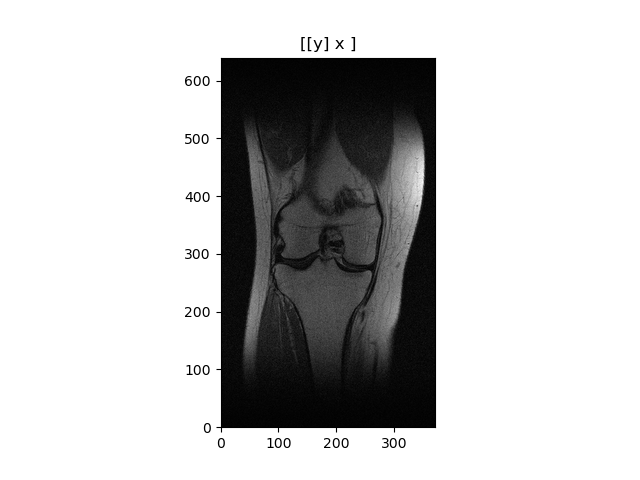

In [46]:
pl.ImagePlot(cplx.to_numpy(target_torch.cpu()))

<IPython.core.display.Javascript object>


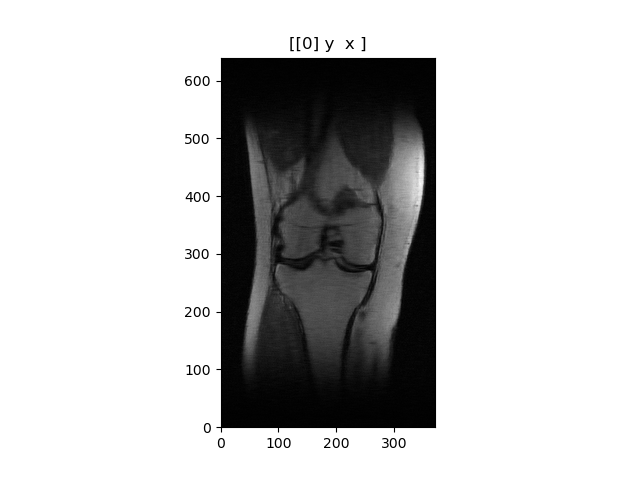

In [43]:
pl.ImagePlot(cplx.to_numpy(im_out.cpu()))